<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/UI_DENEME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Programı ilk açtığınızda mutlaka bir kere çalıştırın. Solda yer alan çalıştır tuşunun yanında yeşil tik olmaması durumunda tekrar çalıştırın. { form-width: "50%", display-mode: "form" }
!pip install -q bta-lib
!pip install -q ta
!pip install -q yfinance
!pip install -U -q git+https://github.com/TechfaneTechnologies/pytvlwcharts.git

import yfinance as yf
from pandas import Timestamp
from pytvlwcharts import *
import btalib
import numpy as np
import pandas as pd
from ta.trend import PSARIndicator
from ta.momentum import WilliamsRIndicator
from ta.trend import AroonIndicator
from ta.volume import VolumePriceTrendIndicator
from ta.trend import CCIIndicator
from ta.momentum import ROCIndicator
from ta.trend import ADXIndicator
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import warnings
from google.colab import drive
import ast

today = datetime.today().date()
tomorrow = today + timedelta(days=1)

start="2021-06-01"
end = tomorrow.strftime("%Y-%m-%d")

balance = 2000

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 500)

def create_indicators(data):
  data["RSI"] = btalib.rsi(data["Close"], period=14).df

  #If little period conflicts with the bigger one it means buy else sell.
  data["SMA5"] = btalib.sma(data['Close'], period=5).df
  data["SMA9"] = btalib.sma(data['Close'], period=9).df
  data["SMA10"] = btalib.sma(data['Close'], period=10).df
  data["SMA14"] = btalib.sma(data['Close'], period=14).df
  data["SMA20"] = btalib.sma(data['Close'], period=20).df
  data["SMA21"] = btalib.sma(data['Close'], period=21).df
  data["SMA50"] = btalib.sma(data['Close'], period=50).df
  data["SMA200"] = btalib.sma(data['Close'], period=200).df

  data["EMA5"] = btalib.ema(data['Close'], period=5).df
  data["EMA14"] = btalib.ema(data['Close'], period=14).df
  data["EMA21"] = btalib.ema(data['Close'], period=21).df
  data["EMA50"] = btalib.ema(data['Close'], period=50).df

  #A reading below 20 generally represents an oversold market and a reading above 80 an overbought market. Look only STOCH-D.
  data["STOCH-K"] = btalib.stoch(data['High'], data['Low'], data['Close']).df["k"]
  data["STOCH-D"] = btalib.stoch(data['High'], data['Low'], data['Close']).df["d"]

  #When the MACD line crosses above the signal line, it generates a buy signal. This indicates a potential bullish trend reversal.
  #Additionally, monitor the MACD histogram. When the histogram bars turn positive (change from negative to positive), it confirms the buy signal and suggests increasing buying pressure.
  data["MACD"] = btalib.macd(data['Close']).df["macd"]
  data["SIGNAL"] = btalib.macd(data['Close']).df["signal"]
  data["HISTOGRAM"] = btalib.macd(data['Close']).df["histogram"]

  #Buy Signal: When the price of the stock touches or crosses below the lower Bollinger Band, it can be considered a buy signal.
  #This suggests that the stock may be oversold, and a potential price rebound is expected.
  #Sell Signal: When the price of the stock touches or crosses above the upper Bollinger Band, it can be considered a sell signal.
  #This indicates that the stock may be overbought, and a potential price correction is expected.
  data["BB-UPPER"] = btalib.bbands(data['Close']).df['top']
  data["BB-MID"] = btalib.bbands(data['Close']).df['mid']
  data["BB-LOWER"] = btalib.bbands(data['Close']).df['bot']

  #When the current price of the stock falls below a certain number of standard deviations (GET THE MIN AND MAX VALUE OF THE COLUMN AND MAKE IT THE THRESHOLD)
  #from the mean, it generates a buy signal. This suggests that the price has deviated significantly from the average and may present a buying opportunity.
  data["STDEV"] = data["Close"].rolling(window=10).std()

  #Generate a buy signal when the price crosses above the PSAR.
  #This indicates a potential reversal in the downward trend and suggests a buying opportunity.
  data["PSAR"] = PSARIndicator(data["High"], data["Low"], data["Close"]).psar()

  #Williams
  #Use the Williams Percent Range (%R) formula to calculate the %R values based on historical price data.
  #The %R values range from -100 to 0, where values close to -100 indicate oversold conditions and values close to 0 indicate overbought conditions.
  #Generate a buy signal when the %R value crosses above a certain threshold (e.g., -80) from below.
  #This indicates a potential reversal from oversold conditions and suggests a buying opportunity.
  data["WILLIAMS"] = WilliamsRIndicator(data["High"], data["Low"], data["Close"]).williams_r()

  #The difference between these two lines indicates whether there is overbought (a positive number) or oversold (a negative number).
  data["AROON"] = AroonIndicator(close=data["Close"], window=25).aroon_indicator()

  #obv
  data["OBV"] = VolumePriceTrendIndicator(close=data['Close'], volume=data['Volume']).volume_price_trend()

  #CCI
  data['CCI'] = CCIIndicator(close=data['Close'], low=data["Low"], high=data["High"], window=14).cci()

  #ROC
  data['ROC'] = ROCIndicator(close=data['Close'], window=5).roc()

  #BULLBEARPOWER
  data['BULL'] = data['High'] - (data['High'].rolling(13).max() + data['Low'].rolling(13).min()) / 2
  data['BEAR'] = data['Low'] - (data['High'].rolling(13).max() + data['Low'].rolling(13).min()) / 2

  #ADX
  adx_indicator = ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
  data['ADX'] = adx_indicator.adx()
  data['+DI'] = adx_indicator.adx_pos()
  data['-DI'] = adx_indicator.adx_neg()

  data = data.dropna()
  data = data.reset_index()
  return data

def buy_or_sell(stock, data, balance, upper_score, lower_score):
  stock_balance = 0
  transactions = []

  for row in range(data.shape[0]):
    if row > 0 and data["SCORE"].iloc[row] >= upper_score and data["SCORE"].iloc[row-1] < upper_score and balance > data["Close"].iloc[row]:
      stock_balance = balance / data["Close"].iloc[row]
      balance-= stock_balance*data["Close"].iloc[row]
      transactions.append([stock, "BUY", data["Date"].iloc[row], data["Close"].iloc[row], stock_balance, balance, data["SCORE"].iloc[row]])

    elif row > 0 and data["SCORE"].iloc[row] <= lower_score and data["SCORE"].iloc[row-1] > lower_score and stock_balance > 1:
      balance+=stock_balance*data["Close"].iloc[row]
      stock_balance-=stock_balance
      transactions.append([stock,"SELL", data["Date"].iloc[row], data["Close"].iloc[row], stock_balance, balance, data["SCORE"].iloc[row]])

  transactions_df = pd.DataFrame(transactions, columns=["STOCK","B/S", "DATE", "PRICE", "STOCK BALANCE", "TRY BALANCE", "SCORE"])
  if transactions_df.empty != True:
    transactions_df["LAST PRICE"] = data["Close"].iloc[-1]
  return transactions_df

def test_the_market(market, buy_threshold, sell_threshold, start, end, balance, today, x):
  test_df = pd.DataFrame()

  for stock in market:
    try:
      data = yf.download(stock, start, end, progress=False)
      data = create_indicators(data)
      data = score(data, x)
      simulation_df = buy_or_sell(stock, data, balance=balance, upper_score=buy_threshold, lower_score=sell_threshold)
      test_df = pd.concat([test_df, simulation_df])

    except:
      print("Data error with stock named: " + stock)

  test_df = test_df.reset_index().drop(["index"], axis=1)
  return_df = pd.DataFrame()

  for stock in market:
    stock_df = test_df[test_df["STOCK"] == stock]

    if stock_df.empty != True:
      if stock_df['B/S'].iloc[-1] == "BUY":
        add = pd.DataFrame({"STOCK": [stock_df["STOCK"].iloc[-1]], "B/S": ["CLOSE"], "DATE": [today], "PRICE": [stock_df["LAST PRICE"].iloc[-1]],
                            'STOCK BALANCE': [0], 'TRY BALANCE': [(stock_df["STOCK BALANCE"].iloc[-1]) * stock_df["LAST PRICE"].iloc[-1]], 'LAST PRICE' :[stock_df["LAST PRICE"].iloc[-1]]})

        stock_df = stock_df.append(add)
        return_df = pd.concat([return_df, stock_df], ignore_index=True)
      else:
        return_df = pd.concat([return_df, stock_df], ignore_index=True)

  return return_df

def score(data, x):
  scaler = MinMaxScaler(feature_range=(0, 100))
  scores = []

  x = ast.literal_eval(x)

  for row in range(data.shape[0]):
    score = 0

    if data["RSI"][row] < 30:
      score+=x[0]
    elif data["RSI"][row] > 70:
      score-=x[1]

    if data["RSI"][row] >= 75:
      score+=x[58]
    elif row > 0 and data["RSI"][row-1] > 73 and data["RSI"][row] < 73:
      score-=x[59]

    if row > 0 and data["RSI"].iloc[row-1] > 63 and data["RSI"].iloc[row] < 63:
      score-=x[2]

    if row > 0 and data["RSI"].iloc[row-1] > 49 and data["RSI"].iloc[row] < 49:
      score-=x[3]
    elif row > 0 and data["RSI"].iloc[row-1] < 50 and data["RSI"].iloc[row] > 50:
      score+=x[4]

    if data["SMA5"].iloc[row] > data["SMA10"].iloc[row]:
      score+=x[5]
    else:
      score-=x[6]

    if row > 0 and data['SMA5'].iloc[row-1] < data['SMA10'].iloc[row-1] and data['SMA5'].iloc[row] > data['SMA10'].iloc[row]:
      score+=x[7]
    else:
      score-=x[8]

    if data["SMA9"][row] > data["SMA14"][row]:
      score+=x[9]
    else:
      score-=x[10]

    if row > 0 and data['SMA9'].iloc[row-1] < data['SMA14'].iloc[row-1] and data['SMA9'].iloc[row] > data['SMA14'].iloc[row]:
      score+=x[11]
    else:
      score-=x[12]

    if data["SMA14"][row] > data["SMA21"][row]:
      score+=x[13]
    else:
      score-=x[14]

    if row > 0 and data['SMA14'].iloc[row-1] < data['SMA21'].iloc[row-1] and data['SMA14'].iloc[row] > data['SMA21'].iloc[row]:
      score+=x[15]
    else:
      score-=x[16]

    if row > 1 and data['SMA20'].iloc[row-1] < data["Close"].iloc[row-1] and data['SMA20'].iloc[row] < data["Close"].iloc[row]:
      score+=x[17]
    else:
      score-=x[18]

    if data["SMA21"][row] > data["SMA50"][row]:
      score+=x[19]
    else:
      score-=x[20]

    if row > 0 and data['SMA21'].iloc[row-1] < data['SMA50'].iloc[row-1] and data['SMA21'].iloc[row] > data['SMA50'].iloc[row]:
      score+=x[21]
    else:
      score-=x[22]

    if row > 0 and data['SMA50'].iloc[row-1] < data['SMA200'].iloc[row-1] and data['SMA50'].iloc[row] > data['SMA200'].iloc[row]:
      score+=x[23]

    if data['Close'][row] > data["EMA14"][row]:
      score+=x[24]
    else:
      score-=x[25]

    if data["EMA5"][row] > data["EMA14"][row]:
      score+=x[26]
    else:
      score-=x[27]

    if row > 0 and data['EMA5'].iloc[row-1] < data['EMA14'].iloc[row-1] and data['EMA5'].iloc[row] > data['EMA14'].iloc[row]:
      score+=x[28]
    else:
      score-=x[29]

    if data["EMA14"][row] > data["EMA21"][row]:
      score+=x[30]
    else:
      score-=x[31]

    if row > 0 and data['EMA14'].iloc[row-1] < data['EMA21'].iloc[row-1] and data['EMA14'].iloc[row] > data['EMA21'].iloc[row]:
      score+=x[32]
    else:
      score-=x[33]

    if data["EMA21"][row] > data["EMA50"][row]:
      score+=x[34]
    else:
      score-=x[35]

    if row > 0 and data['EMA21'].iloc[row-1] < data['EMA50'].iloc[row-1] and data['EMA21'].iloc[row] > data['EMA50'].iloc[row]:
      score+=x[36]
    else:
      score-=x[37]

    if data["STOCH-D"][row] <= 20:
      score+=x[38]
    elif data["STOCH-D"][row] >= 80:
      score-=x[39]

    if row > 0 and data["STOCH-D"][row-1] > 65 and data["STOCH-D"][row] < 65:
      score-=x[40]
    elif row > 0 and data["STOCH-D"][row-1] < 35 and data["STOCH-D"][row] > 35:
      score=+x[41]

    if data["MACD"][row] > data["SIGNAL"][row]:
      score+=x[42]
    if row > 0 and data["MACD"][row] > data["SIGNAL"][row] and data["HISTOGRAM"][row-1] < 0 and data["HISTOGRAM"][row] > 0:
      score+=x[43]
    if row > 0 and data["MACD"][row] < data["SIGNAL"][row] and data["HISTOGRAM"][row-1] > 0 and data["HISTOGRAM"][row] < 0:
      score-=x[44]
    if data["MACD"][row] < data["SIGNAL"][row]:
      score-=x[45]

    if data['MACD'].tail(7).mean() > 0:
      score+=x[46]
    else:
      score-=x[47]

    if data['MACD'].tail(30).mean() > 0:
      score+=x[48]
    else:
      score-=x[49]

    if data["BB-LOWER"].iloc[row] > data["Close"].iloc[row]:
        score+=x[50]
    elif data["BB-UPPER"].iloc[row] < data["Close"].iloc[row]:
        score-=x[51]
    if data["BB-MID"].iloc[row] < data["Close"].iloc[row] and data["BB-LOWER"].iloc[row] - data["Close"].iloc[row] < data["BB-MID"].iloc[row] - data["Close"].iloc[row]:
        score+=x[52]
    elif data["BB-MID"].iloc[row] > data["Close"].iloc[row] and data["BB-UPPER"].iloc[row] - data["Close"].iloc[row] < data["BB-MID"].iloc[row] - data["Close"].iloc[row]:
        score-=x[53]

    if (data["STDEV"].max() + data["STDEV"].min()) / 2 > data["STDEV"][row]:
      score+=1
    else:
      score-=1

    if data["PSAR"][row] < data["Close"][row]:
      score+=1
    else:
      score-=1

    if data["WILLIAMS"][row] < -80:
      score+=1
    elif data["WILLIAMS"][row] > -20:
      score-=1

    if data["AROON"][row] > 0:
      score-=1
    else:
      score+=1

    if row > 0 and data["OBV"][row-1] < data["OBV"][row] and data["Close"][row] > data["Close"][row-1]:
      score+=1
    elif row > 0 and data["OBV"][row-1] > data["OBV"][row] and data["Close"][row] < data["Close"][row-1]:
      score-=1

    if row > 0 and (data['CCI'][row] > -100) & (data['CCI'][row-1] <= -100):
      score+=1
    elif row > 0 and (data['CCI'][row] < 100) & (data['CCI'][row-1] >= 100):
      score-=1

    if data["ROC"][row] > 0:
      score+=1
    elif data["ROC"][row] < 0:
      score-=1

    if data["BULL"][row] > 0:
      score+=1
    elif data["BEAR"][row] < 0:
      score-=1

    if (data['ADX'][row] > 25) and (data['+DI'][row] > data['-DI'][row]):
      score+=x[54]
    if data['ADX'][row] > data['+DI'][row] and data['ADX'][row] > data['-DI'][row]:
      score+=x[55]
    if data['ADX'][row] < data['+DI'][row] and data['ADX'][row] < data['-DI'][row]:
      score-=x[56]
    elif (data['ADX'][row] > 40) and (data['+DI'][row] < data['-DI'][row]):
      score-=x[57]

    scores.append(score)

  data["SCORE"] = scores
  data["SCORE"] = scaler.fit_transform(data["SCORE"].values.reshape(-1, 1))
  return data

In [ ]:
#@title AL veya SAT durumunda olan hisseleri görmek için çalıştırın. { display-mode: "form" }
tarancak_borsa = "XU030" #@param ["XU030", "XUTUM", "COINS"]

if tarancak_borsa == "XU030":
  sheet_id = "1AA9MfqOtAAgO97__aomD79DciyT-PkRQ"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)
elif tarancak_borsa == "XUTUM":
  sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)
elif tarancak_borsa == "COINS":
  sheet_id = "1E7Dk5MN8t7PhlrPqOZ0WOMl9UPUQBknV"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)

def color_boolean(row):
    color = ''

    if row["BUY OR SELL"] == "SELL":
        color = 'red'
    elif row["BUY OR SELL"] == "BUY":
        color = 'green'

    return ['background-color: %s' % color] * len(row)


buy_stocks = []
sell_stocks = []

for stock in result_df["STOCK"].unique():

  stock_df = result_df[result_df["STOCK"] == stock].sort_values(by="PROFIT", ascending=False)
  buy_threshold = stock_df["BUY TH"].iloc[0]
  sell_threshold = stock_df["SELL TH"].iloc[0]
  x = stock_df["WEIGHTS"].iloc[0]

  try:
    data = yf.download(stock, start=start, end=end, progress=False)
    data = create_indicators(data)
    data = score(data, x)

    if data["SCORE"].iloc[-1] > buy_threshold and data["SCORE"].iloc[-2] < buy_threshold:
      buy_stocks.append([data["Date"].iloc[-1], f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock.split(".")[0]}">{stock.split(".")[0]}</a>',
                         data["Close"].iloc[-1], data["SCORE"].iloc[-1], "BUY",
                         "%" + str(round(((data["Close"].iloc[-1]-data["Close"].iloc[-2])/data["Close"].iloc[-2])*100, 2))])

    elif data["SCORE"].iloc[-1] < sell_threshold and data["SCORE"].iloc[-2] > sell_threshold:
      sell_stocks.append([data["Date"].iloc[-1], f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock.split(".")[0]}">{stock.split(".")[0]}</a>',
                          data["Close"].iloc[-1], data["SCORE"].iloc[-1], "SELL",
                          "%" + str(round(((data["Close"].iloc[-1]-data["Close"].iloc[-2])/data["Close"].iloc[-2])*100, 2))])

  except:
    print("Data error at the stock named: " + stock)

buy_df = pd.DataFrame(buy_stocks, columns=["DATE", "STOCK", "PRICE", "SCORE", "BUY OR SELL", "CHANGE"]).sort_values(by="SCORE", ascending=False)
sell_df = pd.DataFrame(sell_stocks, columns=["DATE", "STOCK", "PRICE", "SCORE", "BUY OR SELL", "CHANGE"]).sort_values(by="SCORE", ascending=True)
whole_df = pd.concat([buy_df, sell_df], ignore_index=True)

whole_df = whole_df.style.apply(color_boolean, axis=1).format({col: "{:.2f}" for col in whole_df.select_dtypes(include='float').columns})
whole_df

In [ ]:
#@title Geçmiş AL-SAT verilerini görmek istediğiniz hisse adını girin ve çalıştırın. { display-mode: "form" }
Hisse_adi = "TUPRS" #@param {type:"string"}
Hisse_adi = Hisse_adi.upper()

sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
sheet_name = "Sheet_1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
result_df = pd.read_csv(url)
balance = 2000

if Hisse_adi + ".IS" in result_df["STOCK"].unique():
  stock = Hisse_adi + ".IS"
else:
  balance = 100000
  stock = Hisse_adi + "-USD"
  sheet_id = "1E7Dk5MN8t7PhlrPqOZ0WOMl9UPUQBknV"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)

if stock in result_df["STOCK"].unique():
  profit_or_loss = []
  transactions_df = pd.DataFrame()

  stock_df = result_df[result_df["STOCK"] == stock].sort_values(by="PROFIT", ascending=False)

  buy_threshold = stock_df["BUY TH"].iloc[0]
  sell_threshold = stock_df["SELL TH"].iloc[0]
  x = stock_df["WEIGHTS"].iloc[0]

  test_df = test_the_market([stock], buy_threshold, sell_threshold, start=start, end=end, balance=balance, today=today, x=x)
  transactions_df = pd.concat([transactions_df, test_df], ignore_index=True)

  stock_df = test_df[test_df["STOCK"] == stock]

  if stock_df.empty != True:
    profit_or_loss.append([stock_df["STOCK"].iloc[-1] ,stock_df['TRY BALANCE'].tail(1).item() - balance])

  profit_df = pd.DataFrame(profit_or_loss)

def color_boolean(row):
    color = ''

    if row["B/S"] == "SELL":
        color = 'red'
    elif row["B/S"] == "BUY":
        color = 'green'
    elif row["B/S"] == 'CLOSE':
        color = 'blue'

    return ['background-color: %s' % color] * len(row)

transactions_df[transactions_df["STOCK"] == stock].style.apply(color_boolean, axis=1).format({col: "{:.2f}" for col in transactions_df.select_dtypes(include='float').columns})

In [ ]:
#@title Geçmiş AL-SAT grafiğini görmek istediğiniz hisseyi girin.
stock = "TUPRS" #@param {type:"string"}
stock = stock.upper() + ".IS"

DailyDF = yf.download(stock, start, end, progress=False)
DailyDF = DailyDF.reset_index()
DailyDF = DailyDF.rename(columns = {"Date": "time", "Close": "close", "Open": "open", "High": "high", "Low": "low"})

sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
sheet_name = "Sheet_1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
result_df = pd.read_csv(url)
balance = 2000

stock_df = result_df[result_df["STOCK"] == stock]
transactions_df = pd.DataFrame()
buy_threshold = stock_df["BUY TH"].iloc[0]
sell_threshold = stock_df["SELL TH"].iloc[0]
x = stock_df["WEIGHTS"].iloc[0]

test_df = test_the_market([stock], buy_threshold, sell_threshold, start=start, end=end, balance=balance, today=today, x=x)
test_df = test_df.rename(columns={"DATE": "time", "PRICE": "value"})

closing_price = round(DailyDF["close"].iloc[-1], 2)

DailyChart = Chart(
    data=DailyDF,
    width = 1360,
    height = 500,

    time_scale=TimeScaleOptions(
        seconds_visible=True,
        time_visible=True),

    watermark = WatermarkOptions(
        visible=True,
        text=f"{stock} \n\n {closing_price}₺",
        font_size=16,
        horz_align=HorzAlign("left"),
        vert_align=VertAlign("top"),
        color="black"
    ),
    )

DailyChart.mark_candlestick(data=DailyDF)
[DailyChart.mark_line(data=test_df[i:i+2], color="blue") for i in range(0, test_df.shape[0], 2)]
DailyChart

In [ ]:
#@title Program elinde tuttuğu hisselerden ne kadar karda? { display-mode: "form" }
tarancak_borsa = "XU030" #@param ["XU030", "XUTUM", "COINS"]

if tarancak_borsa == "XU030":
  sheet_id = "1AA9MfqOtAAgO97__aomD79DciyT-PkRQ"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)
elif tarancak_borsa == "XUTUM":
  sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)
elif tarancak_borsa == "COINS":
  sheet_id = "1E7Dk5MN8t7PhlrPqOZ0WOMl9UPUQBknV"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)

program_portfolio = pd.DataFrame()

for stock in result_df["STOCK"].unique():
  try:
    stock_df = result_df[result_df["STOCK"] == stock].sort_values(by="PROFIT", ascending=False)

    buy_threshold = stock_df["BUY TH"].iloc[0]
    sell_threshold = stock_df["SELL TH"].iloc[0]
    x = stock_df["WEIGHTS"].iloc[0]

    test_df = test_the_market([stock], buy_threshold, sell_threshold, start=start, end=end, balance=balance, today=today, x=x)

    if test_df["B/S"].iloc[-1] == "CLOSE":
      program_portfolio = program_portfolio.append(pd.DataFrame(np.array([f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock.split(".")[0]}">{stock.split(".")[0]}</a>',
                                                                          test_df["DATE"].iloc[-2].strftime("%Y-%m-%d"),
                                                                          "%"+str(round(((test_df["LAST PRICE"].iloc[-1]-test_df["PRICE"].iloc[-2])/test_df["PRICE"].iloc[-2])*100, 2))]).reshape(1,3),

                                                                columns=["STOCK", "LAST BUY DATE", "CHANGE"]))
  except:
    pass
program_portfolio = program_portfolio.sort_values(by="LAST BUY DATE", ascending=False)
program_portfolio = program_portfolio.reset_index().drop(["index"], axis=1)

def color_boolean(row):
    color = ''

    if float(row["CHANGE"].split("%")[1]) > 0:
      color = 'green'
    elif float(row["CHANGE"].split("%")[1]) == 0:
      color = 'gray'
    else:
      color='red'
    return ['background-color: %s' % color] * len(row)

program_portfolio.style.apply(color_boolean, axis=1).format({col: "{:.2f}" for col in program_portfolio.select_dtypes(include='float').columns})

In [ ]:
#@title Golden Cross hisseler hangileri? { display-mode: "form" }

tarancak_borsa = "XUTUM" #@param ["XU030", "XUTUM", "COINS"]

if tarancak_borsa == "XU030":
  sheet_id = "1AA9MfqOtAAgO97__aomD79DciyT-PkRQ"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)
elif tarancak_borsa == "XUTUM":
  sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)
elif tarancak_borsa == "COINS":
  sheet_id = "1E7Dk5MN8t7PhlrPqOZ0WOMl9UPUQBknV"
  sheet_name = "Sheet_1"
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  result_df = pd.read_csv(url)

positive_golden_cross = []
negative_golden_cross = []

for stock in result_df["STOCK"].unique():
  try:
    data = yf.download(stock, start=start, end=end, progress=False)
    data["SMA50"] = btalib.sma(data['Close'], period=50).df
    data["SMA200"] = btalib.sma(data['Close'], period=200).df

    if data["SMA50"].iloc[-2] < data["SMA200"].iloc[-2] and data["SMA50"].iloc[-1] > data["SMA200"].iloc[-1]:
      positive_golden_cross.append([f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock.split(".")[0]}">{stock.split(".")[0]}</a>', "+"])
    elif data["SMA50"].iloc[-2] > data["SMA200"].iloc[-2] and data["SMA50"].iloc[-1] < data["SMA200"].iloc[-1]:
      negative_golden_cross.append([f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock.split(".")[0]}">{stock.split(".")[0]}</a>', "-"] )
  except:
    print(f"Hata: {stock}")

def color_boolean(row):
    color = ''
    if row[1] == "+":
      color = 'green'
    else:
      color='red'
    return ['background-color: %s' % color] * len(row)

golden_cross_df = pd.concat([pd.DataFrame(positive_golden_cross), pd.DataFrame(negative_golden_cross)]).reset_index().drop(["index"], axis=1)
golden_cross_df.style.apply(color_boolean, axis=1).format({col: "{:.2f}" for col in golden_cross_df.select_dtypes(include='float').columns})

In [ ]:
#@title Günlük RSI - MACD kesişmeleri.
#@markdown AL Şartları:
#@markdown * RSI-19, RSI-WMA-9'u yukarı yönlü keserse,
#@markdown * MACD Hızlı, MACD Yavaş'ı yukarı yönlü keserse,
#@markdown
#@markdown
#@markdown SAT Şartları:
#@markdown * RSI-19, RSI-WMA-9'u aşağı yönlü keserse,
#@markdown * MACD Hızlı, MACD Yavaş'ı aşağı yönlü keserse,

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from IPython.display import clear_output

current_date = datetime.now()
while current_date.weekday() >= 5:
    current_date -= timedelta(days=1)
formatted_date = current_date.strftime("%Y-%m-%d")

xutum = []

url = f"https://finans.mynet.com/borsa/hisseler/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all("strong", class_="mr-4")

  for element in elements:
    text = element.get_text()
    xutum.append(text.split(" ")[0])

print(f"{formatted_date} için kesişmeler listeleniyor.")

whole_df = pd.DataFrame()

for stock in xutum:
  print(f"{stock} kontrol ediliyor.")
  try:
    data = yf.download(stock+".IS", "2023-07-15", end, progress=False)
    percentage = round(((data["Close"].iloc[-1] - data["Close"].iloc[-2]) / data["Close"].iloc[-2]) * 100, 2)
    daily_change = f"%{percentage}"

    data["RSI"] = btalib.rsi(data["Close"], period=19).df
    data["RSI-WMA"] = btalib.wma(data["RSI"], period=9).df
    data["EMA"] = btalib.ema(data['Close'], period=13).df

    pfast = 3
    pslow = 9

    data["Fast_SMA"] = data['Close'].rolling(window=pfast).mean()
    data["Slow_SMA"] = data['Close'].rolling(window=pslow).mean()

    data["MACD"] = data["Fast_SMA"] - data["Slow_SMA"]
    data["SIGNAL"] = data["MACD"].rolling(window=7).mean()
    data["HISTOGRAM"] = data["MACD"] - data["SIGNAL"]

    data.dropna(inplace=True)
    data.reset_index(inplace=True)

    data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

    if data["MACD"].iloc[-1] > data["SIGNAL"].iloc[-1] and data["MACD"].iloc[-2] < data["SIGNAL"].iloc[-2] and data["RSI"].iloc[-1] > data["RSI-WMA"].iloc[-1] and data["RSI"].iloc[-2] < data["RSI-WMA"].iloc[-2]:
      concat_df = pd.DataFrame([[f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock}">{stock}</a>', daily_change, "AL"]], columns=["HİSSE", "DEĞİŞİM", "AL/SAT"])
      whole_df =  pd.concat([whole_df, concat_df])
    elif data["MACD"].iloc[-1] < data["SIGNAL"].iloc[-1] and data["MACD"].iloc[-2] > data["SIGNAL"].iloc[-2] and data["RSI"].iloc[-1] < data["RSI-WMA"].iloc[-1] and data["RSI"].iloc[-2] > data["RSI-WMA"].iloc[-2]:
      concat_df = pd.DataFrame([[f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock}">{stock}</a>', daily_change, "SAT"]], columns=["HİSSE", "DEĞİŞİM", "AL/SAT"])
      whole_df =  pd.concat([whole_df, concat_df])

  except:
    print(f"{stock} geçiliyor.")

clear_output()
print(f"{formatted_date} için kesişmeler listeleniyor.\n")
def color_boolean(row):
    color = ''
    if row["AL/SAT"] == "AL":
      color = 'green'
    else:
      color='red'
    return ['background-color: %s' % color] * len(row)

whole_df.reset_index(drop=True, inplace=True)
whole_df.style.apply(color_boolean, axis=1)

In [ ]:
#@title Günlük RSI - MACD kesişmeleri (EMA ve Volume dahil).
#@markdown AL Şartları:
#@markdown * RSI-19, RSI-WMA-9'u yukarı yönlü keserse,
#@markdown * MACD Hızlı, MACD Yavaş'ı yukarı yönlü keserse,
#@markdown * Hacim bir önceki günün hacminden büyükse,
#@markdown * Fiyat EMA-13'ün üstündeyse.
#@markdown
#@markdown
#@markdown SAT Şartları:
#@markdown * RSI-19, RSI-WMA-9'u aşağı yönlü keserse,
#@markdown * MACD Hızlı, MACD Yavaş'ı aşağı yönlü keserse,
#@markdown * Hacim bir önceki günün hacminden küçükse,
#@markdown * Fiyat EMA-13'ün altındaysa.

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from IPython.display import clear_output

current_date = datetime.now()
while current_date.weekday() >= 5:
    current_date -= timedelta(days=1)
formatted_date = current_date.strftime("%Y-%m-%d")

xutum = []

url = f"https://finans.mynet.com/borsa/hisseler/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all("strong", class_="mr-4")

  for element in elements:
    text = element.get_text()
    xutum.append(text.split(" ")[0])

print(f"{formatted_date} için kesişmeler listeleniyor.")

whole_df = pd.DataFrame()

for stock in xutum:
  print(f"{stock} kontrol ediliyor.")
  try:
    data = yf.download(stock+".IS", "2023-07-15", end, progress=False)
    percentage = round(((data["Close"].iloc[-1] - data["Close"].iloc[-2]) / data["Close"].iloc[-2]) * 100, 2)
    daily_change = f"%{percentage}"

    data["RSI"] = btalib.rsi(data["Close"], period=19).df
    data["RSI-WMA"] = btalib.wma(data["RSI"], period=9).df
    data["EMA"] = btalib.ema(data['Close'], period=13).df

    pfast = 3
    pslow = 9

    data["Fast_SMA"] = data['Close'].rolling(window=pfast).mean()
    data["Slow_SMA"] = data['Close'].rolling(window=pslow).mean()

    data["MACD"] = data["Fast_SMA"] - data["Slow_SMA"]
    data["SIGNAL"] = data["MACD"].rolling(window=7).mean()
    data["HISTOGRAM"] = data["MACD"] - data["SIGNAL"]

    data.dropna(inplace=True)
    data.reset_index(inplace=True)

    data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

    if data["MACD"].iloc[-1] > data["SIGNAL"].iloc[-1] and data["MACD"].iloc[-2] < data["SIGNAL"].iloc[-2] and data["RSI"].iloc[-1] > data["RSI-WMA"].iloc[-1] and data["RSI"].iloc[-2] < data["RSI-WMA"].iloc[-2] and data["Volume"].iloc[-1] > data["Volume"].iloc[-2] and data["Close"].iloc[-1] > data["EMA"].iloc[-1]:
      concat_df = pd.DataFrame([[f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock}">{stock}</a>', daily_change, "AL"]], columns=["HİSSE", "DEĞİŞİM", "AL/SAT"])
      whole_df =  pd.concat([whole_df, concat_df])
    elif data["MACD"].iloc[-1] < data["SIGNAL"].iloc[-1] and data["MACD"].iloc[-2] > data["SIGNAL"].iloc[-2] and data["RSI"].iloc[-1] < data["RSI-WMA"].iloc[-1] and data["RSI"].iloc[-2] > data["RSI-WMA"].iloc[-2] and data["Volume"].iloc[-1] < data["Volume"].iloc[-2] and data["Close"].iloc[-1] < data["EMA"].iloc[-1]:
      concat_df = pd.DataFrame([[f'<a target="_blank" style="color: white; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock}">{stock}</a>', daily_change, "SAT"]], columns=["HİSSE", "DEĞİŞİM", "AL/SAT"])
      whole_df =  pd.concat([whole_df, concat_df])

  except:
    print(f"{stock} geçiliyor.")

clear_output()
print(f"{formatted_date} için kesişmeler listeleniyor.\n")
def color_boolean(row):
    color = ''
    if row["AL/SAT"] == "AL":
      color = 'green'
    else:
      color='red'
    return ['background-color: %s' % color] * len(row)

whole_df.reset_index(drop=True, inplace=True)
whole_df.style.apply(color_boolean, axis=1)

In [ ]:
#@title Hisse özelinde sinyal geçmişi (RSI-MACD-EMA-VOLUME)
#@markdown * İlk AL sinyalinde alım yapar. İlk SAT sinyalinde satar.
#@markdown * Bakiye başlangıcı 1000 TL.
#@markdown * Tarama başlangıcı 01-01-2020.

hisse_adi = "THYAO" # @param {type:"string"}
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from IPython.display import clear_output

current_date = datetime.now()
while current_date.weekday() >= 5:
    current_date -= timedelta(days=1)
formatted_date = current_date.strftime("%Y-%m-%d")

print(f"{formatted_date} için kesişmeler listeleniyor.")

whole_df = pd.DataFrame()

stock = hisse_adi.upper()
print(f"{stock} kontrol ediliyor.")

try:
  data = yf.download(stock+".IS", "2020-01-01", end, progress=False)
  percentage = round(((data["Close"].iloc[-1] - data["Close"].iloc[-2]) / data["Close"].iloc[-2]) * 100, 2)
  daily_change = f"%{percentage}"

  data["RSI"] = btalib.rsi(data["Close"], period=19).df
  data["RSI-WMA"] = btalib.wma(data["RSI"], period=9).df
  data["EMA"] = btalib.ema(data['Close'], period=13).df

  pfast = 3
  pslow = 9

  data["Fast_SMA"] = data['Close'].rolling(window=pfast).mean()
  data["Slow_SMA"] = data['Close'].rolling(window=pslow).mean()

  data["MACD"] = data["Fast_SMA"] - data["Slow_SMA"]
  data["SIGNAL"] = data["MACD"].rolling(window=7).mean()
  data["HISTOGRAM"] = data["MACD"] - data["SIGNAL"]

  data.dropna(inplace=True)
  data.reset_index(inplace=True)

  signal_df = pd.DataFrame()

  for index, row in data.iterrows():
    if index > 2 and data["MACD"].iloc[index] > data["SIGNAL"].iloc[index] and data["MACD"].iloc[index-1] < data["SIGNAL"].iloc[index-1] and data["RSI"].iloc[index] > data["RSI-WMA"].iloc[index] and data["RSI"].iloc[index-1] < data["RSI-WMA"].iloc[index-1] and data["Volume"].iloc[index] > data["Volume"].iloc[index-1] and data["Close"].iloc[index] > data["EMA"].iloc[index]:
      signal_df = pd.concat([signal_df, pd.DataFrame([[data["Date"].iloc[index], "AL", data["Close"].iloc[index]]], columns=["DATE", "SIGNAL", "PRICE"])])
    if index > 2 and data["MACD"].iloc[index] < data["SIGNAL"].iloc[index] and data["MACD"].iloc[index-1] > data["SIGNAL"].iloc[index-1] and data["RSI"].iloc[index] < data["RSI-WMA"].iloc[index] and data["RSI"].iloc[index-1] > data["RSI-WMA"].iloc[index-1] and data["Volume"].iloc[index] < data["Volume"].iloc[index-1] and data["Close"].iloc[index] < data["EMA"].iloc[index]:
      signal_df = pd.concat([signal_df, pd.DataFrame([[data["Date"].iloc[index], "SAT", data["Close"].iloc[index]]], columns=["DATE", "SIGNAL", "PRICE"])])

  if signal_df.empty != True:
    signal_df['DATE'] = signal_df['DATE'].dt.strftime('%Y-%m-%d')

  balance = 1000
  stock_balance = 0

  for index, row in signal_df.iterrows():
    if row["SIGNAL"] == "AL" and balance > row["PRICE"] and stock_balance == 0:
      stock_balance = int(balance/row["PRICE"])
      balance = balance - stock_balance*row["PRICE"]
    elif row["SIGNAL"] == "SAT" and stock_balance > 0:
      balance = balance + stock_balance*row["PRICE"]
      stock_balance = 0


except:
  print("HATA")

clear_output()
def color_boolean(row):
    color = ''
    if row["SIGNAL"] == "AL":
      color = 'green'
    else:
      color='red'
    return ['background-color: %s' % color] * len(row)

stock_closing_price = data["Close"].iloc[-1]
print(f"{stock} - {round(stock_closing_price, 2)} TL\n")
print(f"Bakiye: {round(balance,2)} TL - Hisse Bakiyesi: {round(stock_balance,2)} Adet")
if stock_balance > 0:
  print(f"Elde Tutulan Hisse Değeri: {round(stock_closing_price*stock_balance, 2)} TL\n")

signal_df.reset_index(drop=True, inplace=True)
signal_df.style.apply(color_boolean, axis=1).format({col: "{:.2f}" for col in signal_df.select_dtypes(include='float').columns})

In [ ]:
#@title RSI-WMA-EMA Tarama
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from IPython.display import clear_output

current_date = datetime.now()
while current_date.weekday() >= 5:
    current_date -= timedelta(days=1)
formatted_date = current_date.strftime("%Y-%m-%d")

xutum = []

url = f"https://finans.mynet.com/borsa/hisseler/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all("strong", class_="mr-4")

  for element in elements:
    text = element.get_text()
    xutum.append(text.split(" ")[0])

print(f"{formatted_date} için kesişmeler listeleniyor.")

whole_df = pd.DataFrame()

for stock in xutum:
  try:
    print(f"{stock} kontrol ediliyor.")
    data = yf.download(stock+".IS", "2023-05-15", end, progress=False)
    percentage = round(((data["Close"].iloc[-1] - data["Close"].iloc[-2]) / data["Close"].iloc[-2]) * 100, 2)
    daily_change = f"%{percentage}"

    hl2 = (data["High"] + data["Low"]) / 2

    data["RSI"] = btalib.rsi(hl2, period=19).df
    data["RSI-WMA"] = btalib.wma(data["RSI"], period=9).df
    data["RSI-EMA"] = btalib.ema(data["RSI"], period=60).df
    data["PRICE-EMA"] = btalib.ema(data["Close"], period=3).df


    data.dropna(inplace=True)
    data.reset_index(inplace=True)

    signal_df = pd.DataFrame()

    rsi_wma_kesme = data["RSI"].iloc[-1] > data["RSI-WMA"].iloc[-1] and data["RSI"].iloc[-2] < data["RSI-WMA"].iloc[-2]
    rsi_ema_kesme = data["RSI"].iloc[-1] > data["RSI-EMA"].iloc[-1] and data["RSI"].iloc[-2] < data["RSI-EMA"].iloc[-2]
    rsi_wma_gun = data["RSI"].iloc[-1] > data["RSI-WMA"].iloc[-1] and data["RSI"].iloc[-2] > data["RSI-WMA"].iloc[-2]
    price_above_ema = data["Close"].iloc[-1] > data["PRICE-EMA"].iloc[-1]

    if (rsi_wma_kesme or rsi_wma_gun or (rsi_wma_kesme and rsi_ema_kesme)) and price_above_ema:
      concat_df = pd.DataFrame([[f'<a target="_blank" style="color: black; font-weight: bold; text-decoration: underline;" href="https://www.tradingview.com/chart/?symbol={stock}">{stock}</a>',
                                    data["Date"].iloc[-1], '+' if rsi_wma_kesme else '-', '+' if rsi_wma_gun else '-', '+' if (rsi_wma_kesme and rsi_ema_kesme) else '-', round(data["Close"].iloc[-1], 2), daily_change]], columns=["HİSSE", "TARİH", "RSI WMA KESİŞME", "RSI WMA 2 GÜN ÜST", "RSI DİĞERLERİNİ KESME", "FİYAT", "GÜNLÜK DEĞİŞİM"])
      whole_df = pd.concat([whole_df, concat_df])
  except:
    print(f"{stock} geçiliyor.")
clear_output()
print(f"{formatted_date} için kesişmeler listeleniyor.\n")

def color_boolean(row):
    color = ''
    if row["RSI WMA KESİŞME"] == "+" and row["RSI DİĞERLERİNİ KESME"] == "+":
      color = 'green'
    elif row["RSI WMA 2 GÜN ÜST"] == "+":
      color = 'white'
    elif row["RSI WMA KESİŞME"] == "+":
      color = 'yellow'
    return ['background-color: %s; color: %s' % (color, "black")] * len(row)

whole_df.reset_index(drop=True, inplace=True)
whole_df.style.apply(color_boolean, axis=1).format({col: "{:.2f}" for col in whole_df.select_dtypes(include='float').columns})

2023-09-29 için kesişmeler listeleniyor.



,HİSSE,TARİH,RSI WMA KESİŞME,RSI WMA 2 GÜN ÜST,RSI DİĞERLERİNİ KESME,FİYAT,GÜNLÜK DEĞİŞİM
0,A1CAP,2023-09-29 00:00:00,-,+,-,43.18,%2.81
1,ACSEL,2023-09-29 00:00:00,-,+,-,101.10,%1.4
2,AFYON,2023-09-29 00:00:00,-,+,-,16.14,%2.15
3,AKBNK,2023-09-29 00:00:00,-,+,-,33.46,%4.43
4,AKENR,2023-09-29 00:00:00,-,+,-,6.03,%5.79
5,AKGRT,2023-09-29 00:00:00,-,+,-,7.80,%0.65
6,AKSA,2023-09-29 00:00:00,-,+,-,102.70,%7.93
7,AKSEN,2023-09-29 00:00:00,+,-,-,41.14,%4.05
8,AKSUE,2023-09-29 00:00:00,-,+,-,30.04,%1.28
9,ALARK,2023-09-29 00:00:00,+,-,-,123.80,%4.47


#Deneme

[*********************100%%**********************]  1 of 1 completed


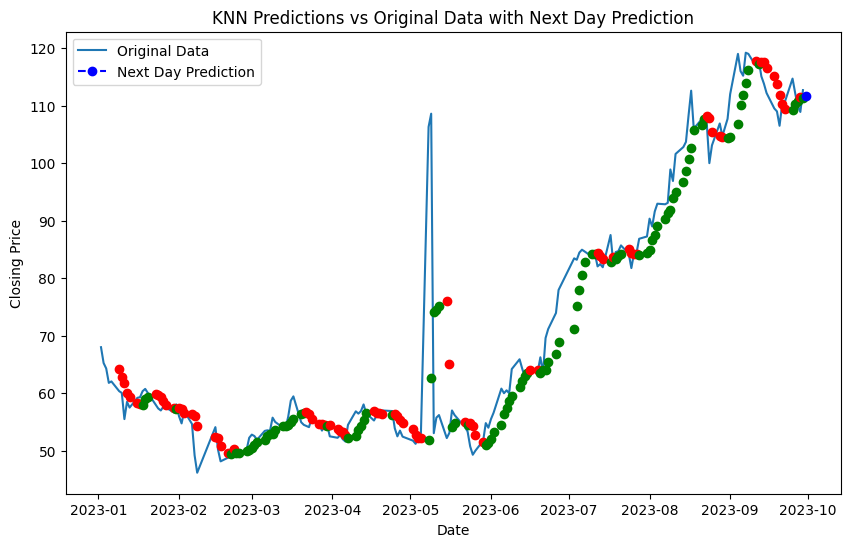

In [130]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def knn_predict(data, k):
    predictions = []

    for i in range(len(data) - k):
        instance = data[i:i+k]
        target = data[i+k]
        distances = np.abs(instance - target)
        nearest_neighbors_indices = np.argsort(distances)[:k]
        nearest_neighbors_values = instance[nearest_neighbors_indices]
        prediction = np.mean(nearest_neighbors_values)
        predictions.append(prediction)
    return predictions

symbol = 'MAVI.IS'
start_date = '2023-01-01'
end_date = '2023-10-01'
yf_data = yf.download(symbol, start=start_date, end=end_date)
data = yf_data["Close"]

yf_data.dropna(inplace=True)
yf_data.reset_index(inplace=True)
yf_data['Date'] = yf_data['Date'].dt.strftime('%Y-%m-%d')

k_value = 5
predictions = knn_predict(data, k_value)

last_instance = data[-k_value:].values
next_day_prediction = np.mean(last_instance)
predictions.append(next_day_prediction)

plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')
for i in range(len(predictions) - 1):
    color = 'green' if predictions[i + 1] > predictions[i] else 'red'
    plt.plot(data.index[k_value + i], predictions[i], marker='o', linestyle='--', color=color)

plt.plot(data.index[-1] + pd.DateOffset(1), next_day_prediction, marker='o', linestyle='--', color='blue', label='Next Day Prediction')

plt.title('KNN Predictions vs Original Data with Next Day Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [131]:
for i in range(len(predictions) - 1):
  if predictions[i+1] > predictions[i] and predictions[i] < predictions[i-1]:
      print(yf_data['Date'][5+i],"AL", round(data[5+i], 2))
  elif predictions[i+1] < predictions[i] and predictions[i] > predictions[i-1]:
      print(yf_data['Date'][5+i],"SAT", round(data[5+i], 2))
      print("\n")

print("\n")
print(yf_data['Date'].iloc[-1], "SON: ",round(data.iloc[-1], 2), " PRED -2: ",round(predictions[-2], 2), " PRED -1: ",round(predictions[-1], 2))

2023-01-18 AL 60.35
2023-01-23 SAT 58.0


2023-01-31 AL 58.05
2023-02-01 SAT 56.0


2023-02-21 AL 50.5
2023-02-22 SAT 50.25


2023-02-23 AL 50.4
2023-03-22 SAT 54.3


2023-03-30 AL 54.5
2023-03-31 SAT 52.5


2023-04-07 AL 54.5
2023-04-17 SAT 55.25


2023-04-24 AL 56.9
2023-04-25 SAT 53.9


2023-05-08 AL 106.3
2023-05-15 SAT 52.2


2023-05-17 AL 57.0
2023-05-22 SAT 54.1


2023-05-23 AL 53.35
2023-05-24 SAT 50.75


2023-05-30 AL 54.8
2023-06-16 SAT 63.95


2023-06-20 AL 66.25
2023-07-12 SAT 82.05


2023-07-17 AL 87.5
2023-07-18 SAT 82.75


2023-07-19 AL 84.55
2023-07-24 SAT 84.25


2023-07-28 AL 86.85
2023-08-23 SAT 106.9


2023-08-31 AL 107.7
2023-09-11 SAT 116.8


2023-09-12 AL 117.9
2023-09-13 SAT 115.1


2023-09-25 AL 114.7
2023-09-28 SAT 108.9


2023-09-29 AL 112.7


2023-09-29 SON:  112.7  PRED -2:  111.26  PRED -1:  111.68


In [122]:
import requests
from bs4 import BeautifulSoup

xutum = []

url = f"https://finans.mynet.com/borsa/hisseler/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all("strong", class_="mr-4")

  for element in elements:
    text = element.get_text()
    xutum.append(text.split(" ")[0])

for stock in xutum:
  try:
    symbol = f'{stock}.IS'
    start_date = '2023-09-01'
    end_date = '2023-10-01'
    yf_data = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data = yf_data["Close"]

    yf_data.dropna(inplace=True)
    yf_data.reset_index(inplace=True)
    yf_data['Date'] = yf_data['Date'].dt.strftime('%Y-%m-%d')

    k_value = 5
    predictions = knn_predict(data, k_value)

    last_instance = data[-k_value:].values
    next_day_prediction = np.mean(last_instance)
    predictions.append(next_day_prediction)

    if predictions[-1] > predictions[-2] and predictions[-2] < predictions[-3]:
        print(stock,"AL")
    elif predictions[-1] < predictions[-2] and predictions[-2] > predictions[-3]:
        print(stock,"SAT")
  except:
    pass

ADESE SAT
ADGYO SAT
AGYO AL
AKSGY AL
ALARK AL
ALKA AL


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALTINS1.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')


ARCLK AL
ARENA AL
ARSAN AL
ATAKP AL
AYCES AL
AYEN AL
BALAT AL
BAYRK AL
BERA SAT
BIENY SAT
BIGCH AL
BIMAS AL
BRMEN SAT
BVSAN AL
CEOEM AL
CIMSA SAT
DAGHL AL
DAGI SAT
DENGE SAT
DERHL AL
DERIM AL
DGATE SAT
DOCO SAT
DOHOL AL
DOKTA SAT
EKGYO AL
EKIZ SAT
ENJSA SAT
ENKAI AL
ERSU AL
EUPWR SAT
FENER AL
FONET SAT
FROTO AL
GARAN AL
GEDIK SAT
GIPTA AL
GLBMD AL
GOKNR SAT
HATEK AL
IHEVA SAT
IHYAY SAT
INGRM AL
IPEKE AL
ISMEN AL
IZFAS AL
KARSN AL
KOZAA AL
KOZAL AL
KSTUR SAT
LUKSK AL
MAALT SAT
MAVI AL
MEGAP SAT
METUR AL
MTRYO AL
ORCAY SAT
OSMEN AL
PINSU AL
RYSAS AL
SANEL SAT
SANFM AL
SILVR SAT
SISE SAT
SUMAS AL
TGSAS SAT
TTKOM AL
TUKAS AL
UFUK AL
VANGD SAT
VESTL SAT
YAYLA AL
YBTAS SAT
YESIL SAT
